In [64]:
'''Fitting an SIRH model to a real dataset. We attempt to learn 
a time dependent parameter beta_t. '''

'Fitting an SIRH model to a real dataset. We attempt to learn \na time dependent parameter beta_t. '

In [65]:
import numpy as np
from epymorph.kit import *
from epymorph.adrio import cdc

import numpy as np
import matplotlib.pyplot as plt
from epymorph.forecasting.likelihood import Poisson
from epymorph.kit import *

from epymorph.simulation import Context
from epymorph.adrio import acs5, us_tiger
from epymorph.forecasting.param_transformations import ExponentialTransform
from epymorph.forecasting.dynamic_params import GaussianPrior, OrnsteinUhlenbeck
from epymorph.adrio.processing import RandomFix

from epymorph.forecasting.pipeline import (
    FromRUME,
    ParticleFilterSimulator,
    Observations,
    ModelLink,
)

from epymorph.attribute import NamePattern

from epymorph.forecasting.pipeline import (
    FromOutput,
    UnknownParam,
)

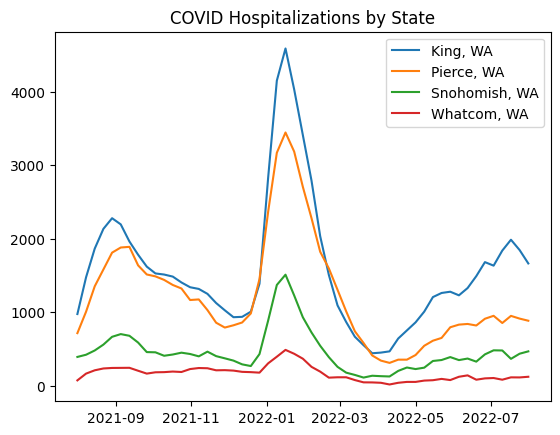

In [66]:
rng = np.random.default_rng(0)
time_frame = TimeFrame.rangex("2021-08-01", "2022-08-01")
scope = CountyScope.in_counties(["King, WA","Pierce, WA","Snohomish, WA","Whatcom, WA"], year=2019)

'''Weekly facility level Hospitalization numbers'''
cdc_adrio = cdc.COVIDFacilityHospitalization(
    age_group="both",  # or "adult", or "pediatric"
    fix_redacted=RandomFix.from_range(1, 3),
    fix_missing=0,
).with_context(
    time_frame=time_frame,
    scope= scope,
    rng = rng
)

real_data_result = cdc_adrio.inspect().result

real_data = real_data_result["value"]
real_data_dates = real_data_result["date"][:, 0]

plt.title('COVID Hospitalizations by State')
for node in range(real_data.shape[1]):
    plt.plot(real_data_dates,real_data[:,node],label = scope.labels[node])
plt.legend()
plt.show()


In [67]:
pf_rume = SingleStrataRUME.build(
    # Load the Pei IPM
    ipm=ipm.SIRH(),
    # Load the Pei MM
    mm=mm.Centroids(),
    # Describe the geographic scope of our simulation:
    scope=scope,
    # Create a SingleLocation initializer
    init=init.RandomLocationsAndRandomSeed(scope.nodes,100_000),
    # Set the time-frame to simulate
    time_frame=time_frame,
    # Provide model parameter values
    params={
        "beta": ExponentialTransform("log_beta"),
        "gamma":1/5,
        "xi":1/90,
        "phi":10,
        "hospitalization_duration": 5.0,
        "hospitalization_prob": 0.15,
        # Geographic data can be loaded using ADRIOs
        "centroid": us_tiger.InternalPoint(),
        "population": acs5.Population()
    },
)

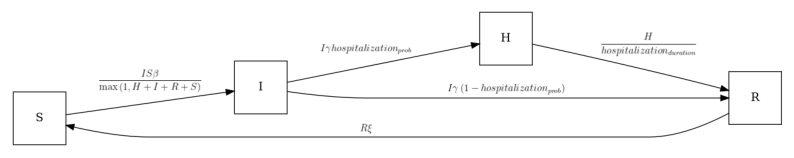

In [68]:
pf_rume.ipm.diagram()

In [69]:
log_beta_damping = 1 / 35
log_beta_mean = np.log(0.22)
log_beta_standard_deviation = 0.30
initial_log_beta = np.log(0.2)

num_realizations = 100

In [70]:
my_observations = Observations(
    source=cdc_adrio,
    model_link=ModelLink(
        geo=pf_rume.scope.select.all(),
        time=pf_rume.time_frame.select.all().group("week").agg(),
        quantity=pf_rume.ipm.select.compartments("H"),
    ),
    likelihood=Poisson(),
)

my_unknown_params = {
    "log_beta": UnknownParam(
        prior=GaussianPrior(
            mean=log_beta_mean,
            standard_deviation=log_beta_standard_deviation,
        ),
        dynamics=OrnsteinUhlenbeck(
            damping=log_beta_damping,
            mean=log_beta_mean,
            standard_deviation=log_beta_standard_deviation,
        ),
    )
}

particle_filter_simulator = ParticleFilterSimulator(
        config=FromRUME(pf_rume,num_realizations,unknown_params = my_unknown_params),
        observations=my_observations,
        save_trajectories=True,
    )


In [71]:
particle_filter_output = particle_filter_simulator.run(rng=rng)

Observation: 0, Label: 2021-07-26, Time Frame: 2021-08-01 (1D), 
Observation: 1, Label: 2021-08-02, Time Frame: 2021-08-02/2021-08-08 (7D), 
Observation: 2, Label: 2021-08-09, Time Frame: 2021-08-09/2021-08-15 (7D), 
Observation: 3, Label: 2021-08-16, Time Frame: 2021-08-16/2021-08-22 (7D), 
Observation: 4, Label: 2021-08-23, Time Frame: 2021-08-23/2021-08-29 (7D), 
Observation: 5, Label: 2021-08-30, Time Frame: 2021-08-30/2021-09-05 (7D), 
Observation: 6, Label: 2021-09-06, Time Frame: 2021-09-06/2021-09-12 (7D), 
Observation: 7, Label: 2021-09-13, Time Frame: 2021-09-13/2021-09-19 (7D), 
Observation: 8, Label: 2021-09-20, Time Frame: 2021-09-20/2021-09-26 (7D), 
Observation: 9, Label: 2021-09-27, Time Frame: 2021-09-27/2021-10-03 (7D), 
Observation: 10, Label: 2021-10-04, Time Frame: 2021-10-04/2021-10-10 (7D), 
Observation: 11, Label: 2021-10-11, Time Frame: 2021-10-11/2021-10-17 (7D), 
Observation: 12, Label: 2021-10-18, Time Frame: 2021-10-18/2021-10-24 (7D), 
Observation: 13, Lab

In [72]:
context = Context.of(
    scope=pf_rume.scope,
    # We fetch data starting from the first fitting date to match the first nowcast.
    time_frame=pf_rume.time_frame,
    rng=rng,
)
real_data_result = (
    my_observations.source.with_context_internal(context).inspect().result
)

real_data = real_data_result["value"]

real_data_dates = real_data_result["date"][:, 0]

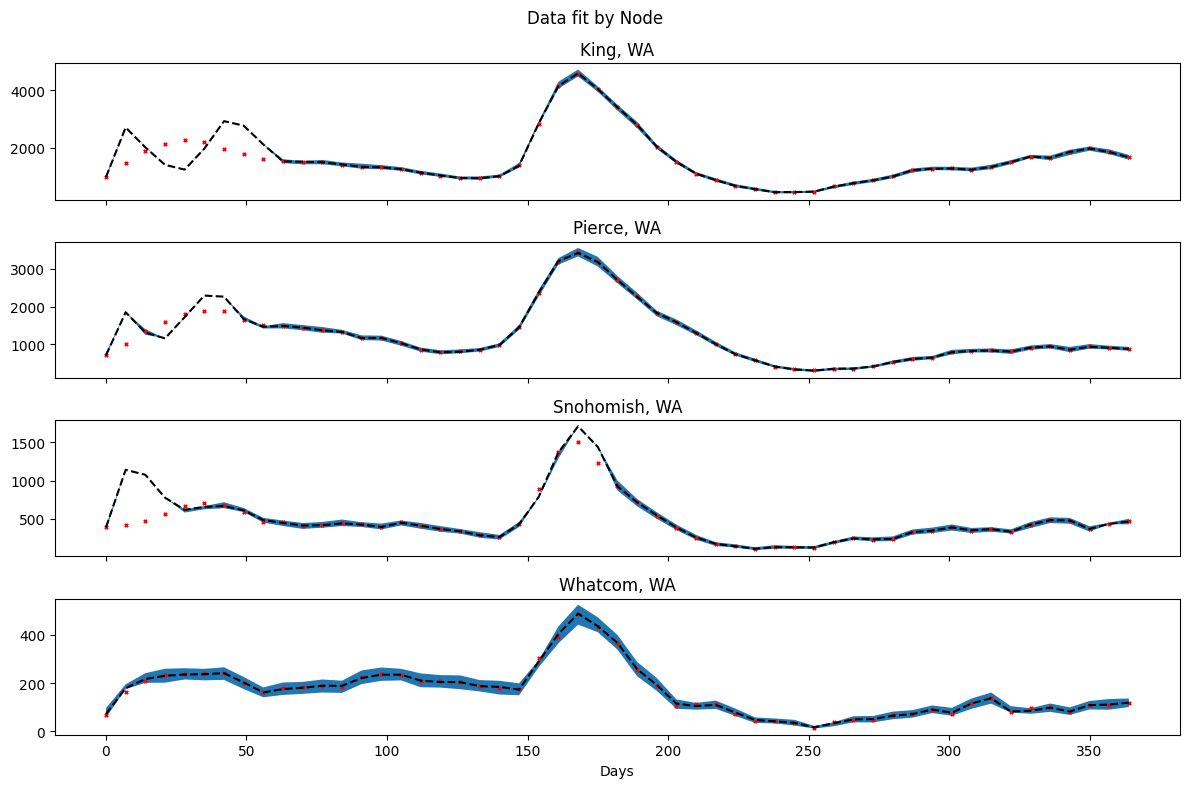

In [73]:
import matplotlib.pyplot as plt

t_range = np.arange(pf_rume.time_frame.duration_days,step = 7)

fig,ax = plt.subplots(4,figsize = (12,8),sharex=True)

plt.suptitle('Data fit by Node')
for node in range(pf_rume.scope.nodes):
        upper = np.percentile(particle_filter_output.posterior_values[:,:,node,:],97.5,axis = 1)[:,0]
        lower = np.percentile(particle_filter_output.posterior_values[:,:,node,:],2.5,axis = 1)[:,0]
        data_mean = np.mean((particle_filter_output.posterior_values[:,:,node,:]),axis = 1)
        ax[node].set_title(f'{pf_rume.scope.labels[node]}')
        ax[node].plot(t_range,data_mean,'--',label = 'mean',color = 'black')
        ax[node].fill_between(t_range,lower,upper)
        ax[node].scatter(t_range,real_data[:,node],marker = 'x',color = 'red',s= 5)
ax[-1].set_xlabel('Days')
fig.tight_layout()

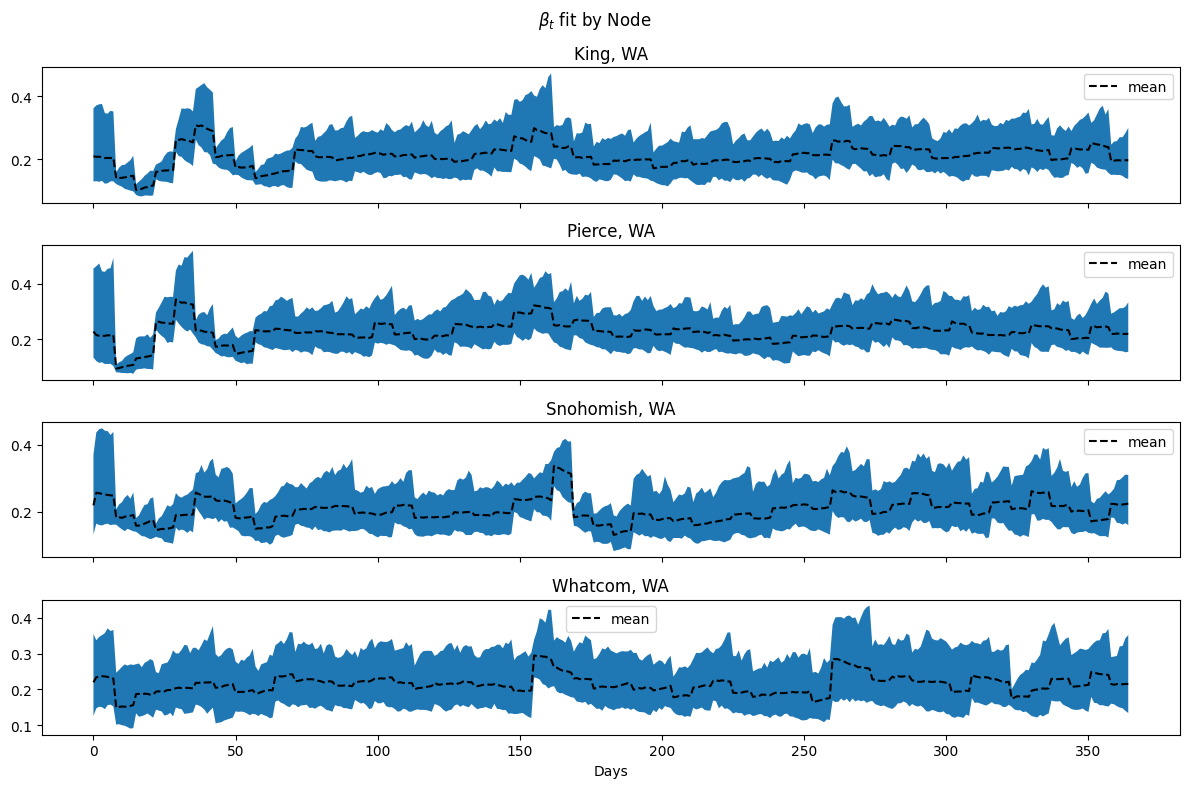

In [74]:
fig,ax = plt.subplots(4,figsize = (12,8),sharex=True)

t_range = np.arange(pf_rume.time_frame.duration_days)

plt.suptitle('$\\beta_t$ fit by Node')
for node in range(pf_rume.scope.nodes):
        upper = np.percentile(np.exp(particle_filter_output.estimated_params[NamePattern.of("log_beta")][:,:,node]),97.5,axis = 0)
        lower = np.percentile(np.exp(particle_filter_output.estimated_params[NamePattern.of("log_beta")][:,:,node]),2.5,axis = 0)
        beta_mean = np.exp(np.mean(particle_filter_output.estimated_params[NamePattern.of("log_beta")][:,:,node],axis = 0))
        ax[node].set_title(f'{pf_rume.scope.labels[node]}')
        ax[node].fill_between(t_range,lower,upper)
        ax[node].plot(beta_mean,'--',label = 'mean',color = 'black')
        ax[node].legend()
ax[-1].set_xlabel('Days')
fig.tight_layout()
